# Проект для "Викишоп"

Обучение модели, способной классифицировать позитивные и негативные комментарии на основе набора с разметкой о токсичности пользовательских правок описаний товаров в интернет-магазине "Викишоп" с целью выявления и предотвращения токсичных комментариев.

Необходимо добиться значения метрики качества `F1` не меньше `0.75`.

**Ход исследования:**
* Загрузка данных и первичное ознакомление с ними;

* Подготовка данных к работе:
    
    * Очистка и лемматизация текста;
    
    * Разделение данных на выборки;
    
    * Выделение признаков из текстовых данных;

* Обучение разных моделей:

    * Модель логистической регрессии `LogisticRegression`;
    
    * Модель градиентного бустинга `CatBoostClassifier`;
    
    * Модель градиентного бустинга `XGBClassifier`;
    
    * Модель градиентного бустинга `LGBMClassifier`;
    
* Анализ скорости работы и качества моделей;

* Итоги исследования.

## Загрузка данных

In [2]:
!pip install xgboost

  Using cached xgboost-1.6.1-py3-none-win_amd64.whl (125.4 MB)


In [4]:
!pip install catboost

  Using cached graphviz-0.20-py3-none-any.whl (46 kB)


In [5]:
!pip install lightgbm

  Using cached lightgbm-3.3.2-py3-none-win_amd64.whl (1.0 MB)


In [1]:
# Подключение необходимых библиотек

import pandas as pd
import seaborn as sns
import re
import numpy as np
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords, wordnet
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import time
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
import warnings

warnings.filterwarnings('ignore')

In [9]:
nltk.download('wordnet')

# для nltk.pos_tag()
nltk.download('averaged_perceptron_tagger')

# для nltk.word_tokenize()
nltk.download('punkt')

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\y_gri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Прочитаем данные из файла `/datasets/toxic_comments.csv`:

In [2]:
# локально
#df = pd.read_csv('toxic_comments.csv')
# ЯП
df = pd.read_csv('/datasets/toxic_comments.csv')

df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


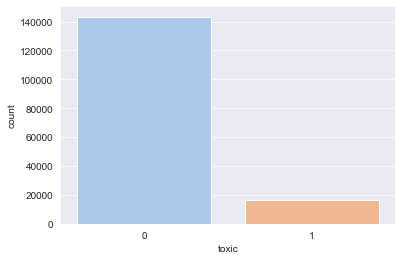

In [23]:
sns.set_style('darkgrid')
sns.countplot(x='toxic', data=df, palette='pastel')

**Вывод:**

Итак, у нас есть 159 тысяч объектов, содержащих пока что не обработанные англоязычные комментарии и соответсвующие им значения целевого признака `toxic`. Заметим, что негативных комментариев в датафрейме гораздо меньше, чем нейтральных. Чтобы подготовить данные стобца `text` к обучению на них моделей, необходимо упростить его, а затем извлечь из него признаки для обучения. 

## Подготовка данных к работе

Сначала очистим комментарии  из столбца `text` от ненужных символов, оставив только слова и пробелы, а затем лемматизируем их. Лемматизацию проведем используя лемматизатор `Wordnet` из библиотеки `nltk`. Для этого создадим соответсвующие функции:

In [3]:
# функция определения POS-тегов (указывает на часть речи в данном контексте) для каждого слова

def get_wordnet_pos(text):
    tag = nltk.pos_tag([text])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [4]:
lemmatizer = WordNetLemmatizer()

In [5]:
# функция лемматизации текста с помощью wordnet

def lemmatize_wordnet(text):
    words = nltk.word_tokenize(text)
    lemm_list = " ".join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words])
    return lemm_list

In [6]:
# функция очистки текста от лишних символов с использованием регулярных выражений 
# и приведение к нижнему регистру

def clear_text(text):
    result = " ".join(re.sub(r"[^a-zA-Z' ]", " ", text).lower().split())
    return result

Применим функции ко всем имеющимся данным.

In [8]:
%%time
df['text_lemm'] = df['text'].apply(lambda text: lemmatize_wordnet(clear_text(text)))

Wall time: 1h 54min 38s


In [19]:
df.head()

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm see...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it 's ...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Так как преобразование занимает довольно долгое время, сразу сохраним полученные результаты в новой таблице, чтобы в дальнейшем не повторять времязатратный процесс лемматизации.

In [10]:
df.to_csv('toxic_comments_lemm.csv', index=False)

In [2]:
df = pd.read_csv('toxic_comments_lemm.csv')

Теперь разделим датасет на обучающую и тестовую выборки в соотношении 3:1. В качестве признаков оставим только целевой (`toxic`) и лемматизированные тексты (`text_lemm`).

In [3]:
features, target = df['text_lemm'], df['toxic']

# выделение обучающей и тестовой выборок размером 75% и 25%
train_ft, test_ft, train_tg, test_tg = train_test_split(features, target, test_size=0.25, random_state=111)

In [19]:
train_ft = train_ft.fillna('')
test_ft = test_ft.fillna('')

На всякий случай проверим размеры выборок:

In [6]:
print(f'Объем обучающей выборки: {train_ft.shape[0]} объектов')
print(f'Объем тестовой выборки: {test_ft.shape[0]} объектов')

Объем обучающей выборки: 119678 объектов
Объем тестовой выборки: 39893 объектов


Ранее был замечен сильный дисбаланс классов. Сделаем балансировку используя технику увеличения выборки `upsampling`.

In [7]:
def upsample(ft, tg, repeat):
    ft_zeros = ft[tg == 0]
    ft_ones = ft[tg == 1]
    tg_zeros = tg[tg == 0]    
    tg_ones = tg[tg == 1]    
    
    ft_upsampled = pd.concat(
        [ft_zeros] + [ft_ones] * repeat)    
    tg_upsampled = pd.concat(
        [tg_zeros] + [tg_ones] * repeat)    
    ft_upsampled, tg_upsampled = shuffle(        
        ft_upsampled, tg_upsampled, random_state=111) 
    
    return ft_upsampled, tg_upsampled

In [8]:
train_ft, train_tg = upsample(train_ft, train_tg, 6)

In [9]:
print(train_tg.value_counts(normalize=True))
test_tg.value_counts(normalize=True)

0    0.594815
1    0.405185
Name: toxic, dtype: float64


0    0.899155
1    0.100845
Name: toxic, dtype: float64

Теперь займемся выделением признаков. Для этого создадим корпуса текстов для обучающей и тестовой выборок и переведем лемматизированные тексты в векторный формат с помощью мешка слов и очистим их от стоп-слов (не несущих смысловой нагрузки). После чего с помощью расчета `TF-IDF` проведем оценку важности каждого из слов в корпусах текстов.

Однако так как при обучении моделей будем подбирать гиперпараметры с помощью кросс-валидации, обучать векторизатор будем не на всей выборке заранее, а во время кросс-валидации, чтобы избежать возможного переобучения.

Пока что загрузим словарь английских стоп-слов для векторизатора.

In [10]:
# загрузка словаря английских стоп-слов

stopwords = set(nltk_stopwords.words('english'))

**Вывод:**

На этапе предобработки данных произошли следующие изменения:

* Тексты были очищены от ненужных символов с помощью регулярных выражений и лемматизированы;
* Данные разделены на обучающую и тестовую выборки в соотношении 75% и 25%;
* Данные были сбалансированы с помощью техники увеличения выборки. 
* Лемматизированные тексты приведены в векторный вид и с помощью мешка слов и расчета TF-IDF из них созданы признаки для обучения моделей. 

## Обучение моделей

Оценку качества моделей будем проводить с помощью метрики `F1-score`.

Проверим в действии следующие модели:

 * Модель логистической регрессии `LogisticRegression`;
     
 * Модель градиентного бустинга `XGBClassifier`;
    
 * Модель градиентного бустинга `CatBoostClassifier`;
    
 * Модель градиентного бустинга `LGBMClassifier`;
    
 * Модель классификации текстов `BERT`.
 
Подберем для них наилучшие гиперпараметры с помощью кросс-валидации на обучающей выбрке и проверим качество их предсказаний с помощью метрики `F1` на тестовой выборке.

Так как процедура обучения и предсказания для всех моделей будет примерно одинакова, создадим отдельные функции, отвечающие за это и за расчет времени:

In [12]:
# функция обучения моделей и расчета времени

def fit_model(model_name, classifier, train_ft, train_tg):
    time0 = time.time()
    model = classifier
    model.fit(train_ft, train_tg)
    time_fit = round(time.time() - time0, 4)
    
    print(f'Время обучения модели {model_name}: {time_fit} секунд')
    
    return model, time_fit

In [13]:
# функция предсказания модели для тестовой выборки и проверки метрики f1

def pred_model(model_name, model, test_ft, test_tg):
    predictions = model.predict(test_ft)
    f1 = f1_score(predictions, test_tg).round(4)
    
    print(f'F1-score для модели {model_name} на тестовой выборке: {f1}')
    
    return f1

Приступим к обучению моделей.

### Логистическая регрессия

Начнем с модели логистической регрессии. Выставим гиперпараметры для кросс-валидации и посмотрим на результаты. 

In [15]:
%%time

pipe_lr = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
    ('model', LogisticRegression(n_jobs=-1, class_weight='balanced', solver='lbfgs', random_state=111))
])

params = {'model__C': [0.1, 0.5, 1, 5, 10, 25]}

clf = GridSearchCV(pipe_lr, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
clf.fit(train_ft, train_tg)

display(clf.best_estimator_, clf.best_params_, clf.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LogisticRegression(C=25, class_weight='balanced', n_jobs=-1,
                                    random_state=111))])

{'model__C': 25}

0.9665141322564995

CPU times: total: 13 s
Wall time: 2min 34s


In [17]:
# обучение модели логистической регрессии с выбранными гиперпараметрами на трейне и расчет времени

model_logreg, time_logreg = fit_model("LogisticRegression", clf.best_estimator_, train_ft, train_tg)

Время обучения модели LogisticRegression: 13.5636 секунд


In [20]:
# Предсказания для тестовой выборки, расчет метрики качества

f1_logreg = pred_model('LogisticRegression', model_logreg, test_ft, test_tg)

F1-score для модели LogisticRegression на тестовой выборке: 0.7416


In [21]:
# Вывод результатов обучения модели логистической регрессии

result = []

result.append({'Модель' : 'LogisticRegression', 
              'Параметры': clf.best_params_, 
              'Время обучения': f'{time_logreg} sec',  
              'F1-score': f1_logreg})

pd.DataFrame(result)

,Модель,Параметры,Время обучения,F1-score
0,LogisticRegression,{'model__C': 25},13.5636 sec,0.7416


### Градиентный бустинг XGBoost

Рассмотрим следующую модель: модель экстремального градиентного бустинга `XGBoost`

In [24]:
%%time

pipe_xgb = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
    ('model', XGBClassifier(n_jobs=-1, booster='gbtree', random_state=111))
])

params = {'model__max_depth': [4, 6, 8], 
         'model__n_estimators': [50, 100, 200]}

clf = GridSearchCV(pipe_xgb, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
clf.fit(train_ft, train_tg)

display(clf.best_estimator_, clf.best_params_, clf.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               co...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012,

{'model__max_depth': 8, 'model__n_estimators': 200}

0.9217520504340331

CPU times: total: 13min 38s
Wall time: 38min


In [25]:
# Обучение модели XGB c выбранными гиперпарметрами на тренировоной выборке и расчет времени

model_xgb, time_xgb = fit_model('XGBClassifier', clf.best_estimator_, train_ft, train_tg)

Время обучения модели XGBClassifier: 224.1305 секунд


In [26]:
# Предсказания для тестовой выборки, расчет метрики качества

f1_xgb = pred_model('XGBClassifier', model_xgb, test_ft, test_tg)

F1-score для модели XGBClassifier на тестовой выборке: 0.7742


In [27]:
# Вывод результатов обучения модели XGB

result.append({'Модель' : 'XGBClassifier', 
              'Параметры': clf.best_params_, 
              'Время обучения': f'{time_xgb} sec',  
              'F1-score': f1_xgb})

pd.DataFrame(result)

,Модель,Параметры,Время обучения,F1-score
0,LogisticRegression,{'model__C': 25},13.5636 sec,0.7416
1,XGBClassifier,"{'model__max_depth': 8, 'model__n_estimators':...",224.1305 sec,0.7742


### Градиентный бустинг CatBoost

Обучим модель градиентного бустинга `CatBoost`. 

In [28]:
%%time

pipe_cat = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
    ('model', CatBoostClassifier(verbose=0, random_state=111))
])

params = {'model__iterations': [100, 200, 500]}

clf = GridSearchCV(pipe_cat, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
clf.fit(train_ft, train_tg)

display(clf.best_estimator_, clf.best_params_, clf.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x0000020E9BFCB430>)])

{'model__iterations': 100}

nan

CPU times: total: 11min 17s
Wall time: 9min 21s


In [29]:
# Обучение модели CatBoostClassifier c выбранными гиперпарметрами на тренировоной выборке и расчет времени

model_cat, time_cat = fit_model('CatBoostClassifier', clf.best_estimator_, train_ft, train_tg)

Время обучения модели CatBoostClassifier: 215.7639 секунд


И узнаем качество нашей модели на тестовой выборке:

In [30]:
# Предсказания для тестовой выборки, расчет метрики качества

f1_cat = pred_model('CatBoostClassifier', model_cat, test_ft, test_tg)

F1-score для модели CatBoostClassifier на тестовой выборке: 0.7512


In [31]:
# Вывод результатов обучения модели CatBoostClassifier

result.append({'Модель' : 'CatBoostClassifier', 
              'Параметры': clf.best_params_, 
              'Время обучения': f'{time_cat} sec',  
              'F1-score': f1_cat})

pd.DataFrame(result)

,Модель,Параметры,Время обучения,F1-score
0,LogisticRegression,{'model__C': 25},13.5636 sec,0.7416
1,XGBClassifier,"{'model__max_depth': 8, 'model__n_estimators':...",224.1305 sec,0.7742
2,CatBoostClassifier,{'model__iterations': 100},215.7639 sec,0.7512


### Градиентный бустинг LightGBM

Следующая модель: модель градиентого бустинга `LightGBM`. С ней работаем все по той же схеме. 

In [32]:
%%time

pipe_lgbm = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopwords)),
    ('model', LGBMClassifier(random_state=111))
])

params = {'model__max_depth': [4, 6, 8], 
         'model__n_estimators': [50, 100, 200], 
         'model__learning_rate': [0.1, 0.03]}

clf = GridSearchCV(pipe_lgbm, param_grid=params, scoring='f1', cv=3, n_jobs=-1)
clf.fit(train_ft, train_tg)

display(clf.best_estimator_, clf.best_params_, clf.best_score_)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LGBMClassifier(max_depth=8, n_estimators=200,
                                random_state=111))])

{'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__n_estimators': 200}

0.8664075618087943

CPU times: total: 3min 58s
Wall time: 20min 45s


In [33]:
# Обучение модели LightGBM c выбранными гиперпарметрами на тренировоной выборке и расчет времени

model_lgbm, time_lgbm = fit_model('LGBMClassifier', clf.best_estimator_, train_ft, train_tg)

Время обучения модели LGBMClassifier: 63.7614 секунд


In [34]:
# Предсказания для тестовой выборки, расчет метрики качества

f1_lgbm = pred_model('LGBMClassifier', model_lgbm, test_ft, test_tg)

F1-score для модели LGBMClassifier на тестовой выборке: 0.758


In [35]:
# Вывод результатов обучения модели LightGBM

result.append({'Модель' : 'LGBMClassifier', 
              'Параметры': clf.best_params_, 
              'Время обучения': f'{time_lgbm} sec',  
              'F1-score': f1_lgbm})

pd.DataFrame(result)

,Модель,Параметры,Время обучения,F1-score
0,LogisticRegression,{'model__C': 25},13.5636 sec,0.7416
1,XGBClassifier,"{'model__max_depth': 8, 'model__n_estimators':...",224.1305 sec,0.7742
2,CatBoostClassifier,{'model__iterations': 100},215.7639 sec,0.7512
3,LGBMClassifier,"{'model__learning_rate': 0.1, 'model__max_dept...",63.7614 sec,0.7580


## Анализ моделей

Соберем все полученные результаты воедино:

In [36]:
pd.DataFrame({'Модель': ['LogisticRegression', 'XGBClassifier', 'CatBoostClassifier', 'LGBMClassifier'], 
             'Время обучения': [time_logreg, time_xgb, time_cat, time_lgbm], 
             'F1-score': [f1_logreg, f1_xgb, f1_cat, f1_lgbm]})

,Модель,Время обучения,F1-score
0,LogisticRegression,13.5636,0.7416
1,XGBClassifier,224.1305,0.7742
2,CatBoostClassifier,215.7639,0.7512
3,LGBMClassifier,63.7614,0.7580


## Итоги исследования

* Были опробованы 4 модели: логистическая регрессия, XGBoost, CatBoost и LightGBM, а качество их предсказаний оценикалось метрикой f1-score.
* Наиболее быстрой по времени обучения оказалась модель логистической регрессии, но ее F1-score не достигает необходимого порога. 
* Наиболее высокого результата метрики f1 удалось достичь модели `XGBClassifier`, однако по времени обучения она стала самой медленной из всех использованных моделей обучения.  